All the saved models (.pkl files) can be downloaded from https://drive.google.com/drive/folders/1Bky4TD7KmnDyZnjbG_crRWMxwfrjGTI2?usp=share_link or they can be imported from the "Trained Models" folder submitted along with this notebook.

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_union
import pickle

In [3]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1b0BcOqd8kv_6qhtKdBEeVPt7XjoqSego'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv') 


In [5]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()

In [7]:
def feature_engineering(df, sparse=0): 
    
    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))
    

    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Mean Word length 
    def word_length(s):
        s = s.split(' ')
        return np.mean([len(w) for w in s if w.isalpha()])
    df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

    # Average number of exclamation points 
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks 
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))

    # Strip IP Addresses
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))
    
    return df

def merge_features(comment_text, data, engineered_features):
    new_features = sparse.csr_matrix(data[engineered_features].values)
    if np.isnan(new_features.data).any():
        new_features.data = np.nan_to_num(new_features.data)
    return sparse.hstack([comment_text, new_features])

In [8]:
df = feature_engineering(df)
df.head()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,caps,word_length,exclamation,question
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0.083333,4.500000,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0.108108,6.250000,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0.021390,4.638889,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0.022587,4.212766,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0.039216,4.125000,0,1


In [9]:
with open('MinMaxScaler.pkl', 'rb') as file:
  scaler = pickle.load(file)

df[['length', 'caps', 'word_length', 'question', 'exclamation']] = scaler.transform(df[['length', 'caps', 'word_length', 'question', 'exclamation']])

In [10]:
with open('vectorizer.pkl', 'rb') as file:
  comment_vector = pickle.load(file)

In [11]:
print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)

toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)
targets.append('any_label')
df_targets['any_label'] = toxic_rows.astype(int)

new_features = list(df.columns[1:])

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(159571, 6)

Training data
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(159571, 6)


In [12]:
downloaded = drive.CreateFile({'id':'1Td1nh_L8W3cRt0Y193hvg2qSNxGJA5iH'})
downloaded.GetContentFile('trainmatrix.npz') 

In [13]:
X = sparse.load_npz("trainmatrix.npz")

In [14]:
from sklearn.model_selection import train_test_split
#60% 20% 20% split
X_train_validate, X_test, y_train_validate, y_test,  = train_test_split(X, df_targets, test_size=0.2, random_state=0)
#X_train, X_validate, y_train, y_validate,  = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state=0)

In [15]:
downloaded = drive.CreateFile({'id':'1Td1nh_L8W3cRt0Y193hvg2qSNxGJA5iH'})
downloaded.GetContentFile('trainmatrix.npz') 

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def model_evaluate(X_train, Y_train, X_test, Y_test, model_name):
  labels = Y_train.columns

  for label in labels:
    
    with open('%s_%s.pkl' %(model_name, label), 'rb') as file:
      model = pickle.load(file)

    #Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    #F1-scores
    #Training Report
    report_train = classification_report(Y_train[label], train_pred)
    print("Training Classification Report for %s label:\n" % label,report_train)

    #Getting confusion matrix for Training Data
    cm_train = confusion_matrix(Y_train[label], train_pred, labels=model.classes_)

    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm_train, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm_train.shape[0]):
        for j in range(cm_train.shape[1]):
            ax.text(x=j, y=i,s=cm_train[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.title("Training Confusion Matrix for %s" % label, fontsize=18)
    plt.show()

    #Testing Report
    report_test = classification_report(Y_test[label], test_pred)
    print("Testing Classification Report for %s label:\n" % label,report_test)

    #Getting confusion matrix for Validation Data
    cm_test = confusion_matrix(Y_test[label], test_pred, labels=model.classes_)

    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm_test, cmap=plt.cm.YlOrRd, alpha=0.3)
    for i in range(cm_test.shape[0]):
        for j in range(cm_test.shape[1]):
            ax.text(x=j, y=i,s=cm_test[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.title("Testing Confusion Matrix for %s" % label, fontsize=18)
    plt.show()

  return

In [17]:
def feature_engineering_predict(df, scaler, sparse=0): 
    
    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))
    

    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Mean Word length 
    def word_length(s):
        s = s.split(' ')
        return np.mean([len(w) for w in s if w.isalpha()])
    df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

    # Average number of exclamation points 
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks 
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
    
    # Normalize
    labels = ['length', 'caps', 'word_length', 'question', 'exclamation']
    df[labels] = scaler.transform(df[labels])

    # Strip IP Addresses
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))
    
    return df

In [29]:
def predict_custom(cust_string: str, vectorizor, scaler, model: str):
  df = pd.DataFrame({'comment_text': [cust_string]})

  #print(df)

  comment = vectorizor.transform(df.comment_text)
  df = feature_engineering_predict(df, scaler)
  processed_input = merge_features(comment, df, new_features)
  results = {}

  for label in ['toxic','threat','severe_toxic','obscene','insult','identity_hate','any_label']:
    with open('%s_%s.pkl' %(model,label), 'rb') as file:
      MLmod = pickle.load(file)
      results[label] = list(MLmod.predict(processed_input))

  toxic_comment = "Your comment is toxic under labels: "
  results.pop('any_label')
  flag = 0
  for label,val in results.items():
    if val[0] == 1:
      flag = 1
      toxic_comment = toxic_comment + "\n%s" %label
  
  if flag == 0:
    return "Your comment is not toxic."

  return toxic_comment

Training Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    115463
           1       0.71      0.74      0.72     12193

    accuracy                           0.95    127656
   macro avg       0.84      0.85      0.85    127656
weighted avg       0.95      0.95      0.95    127656



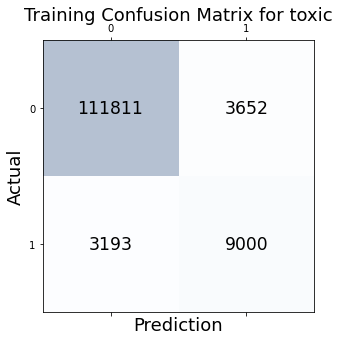

Testing Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     28814
           1       0.71      0.71      0.71      3101

    accuracy                           0.94     31915
   macro avg       0.84      0.84      0.84     31915
weighted avg       0.94      0.94      0.94     31915



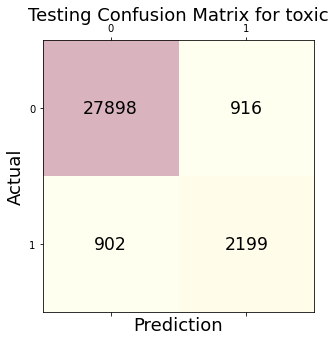

Training Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    126390
           1       0.39      0.67      0.49      1266

    accuracy                           0.99    127656
   macro avg       0.69      0.83      0.74    127656
weighted avg       0.99      0.99      0.99    127656



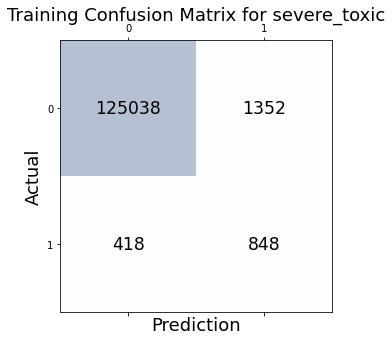

Testing Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     31586
           1       0.36      0.61      0.45       329

    accuracy                           0.98     31915
   macro avg       0.68      0.80      0.72     31915
weighted avg       0.99      0.98      0.99     31915



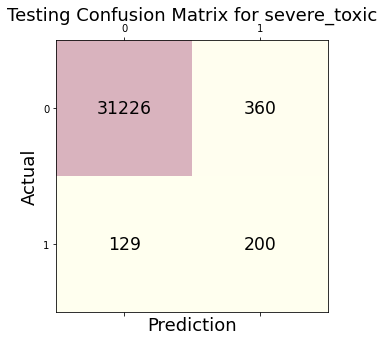

Training Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    120905
           1       0.68      0.77      0.72      6751

    accuracy                           0.97    127656
   macro avg       0.83      0.87      0.85    127656
weighted avg       0.97      0.97      0.97    127656



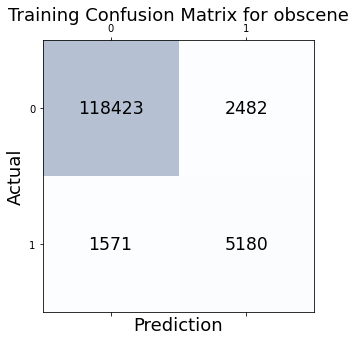

Testing Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     30217
           1       0.65      0.74      0.69      1698

    accuracy                           0.97     31915
   macro avg       0.82      0.86      0.84     31915
weighted avg       0.97      0.97      0.97     31915



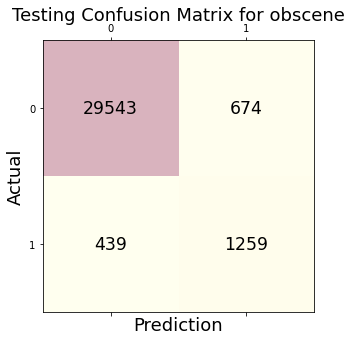

Training Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    127269
           1       0.31      0.09      0.14       387

    accuracy                           1.00    127656
   macro avg       0.66      0.54      0.57    127656
weighted avg       1.00      1.00      1.00    127656



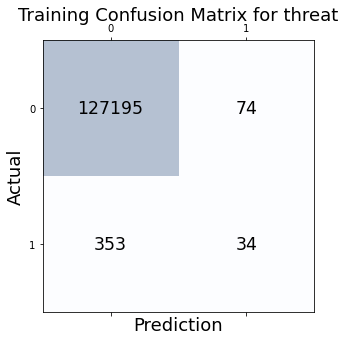

Testing Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31824
           1       0.31      0.09      0.14        91

    accuracy                           1.00     31915
   macro avg       0.65      0.54      0.57     31915
weighted avg       1.00      1.00      1.00     31915



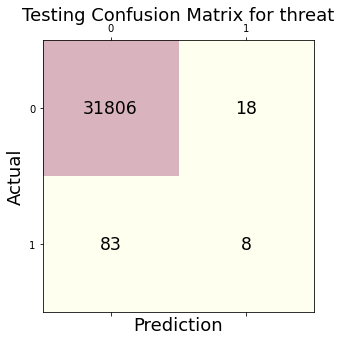

Training Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    121373
           1       0.61      0.73      0.66      6283

    accuracy                           0.96    127656
   macro avg       0.80      0.85      0.82    127656
weighted avg       0.97      0.96      0.97    127656



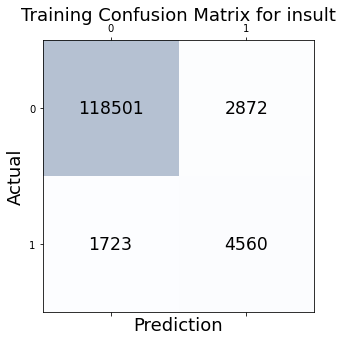

Testing Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     30321
           1       0.60      0.71      0.65      1594

    accuracy                           0.96     31915
   macro avg       0.79      0.84      0.82     31915
weighted avg       0.97      0.96      0.96     31915



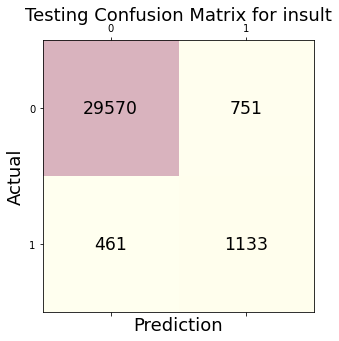

Training Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    126549
           1       0.27      0.38      0.32      1107

    accuracy                           0.99    127656
   macro avg       0.63      0.69      0.66    127656
weighted avg       0.99      0.99      0.99    127656



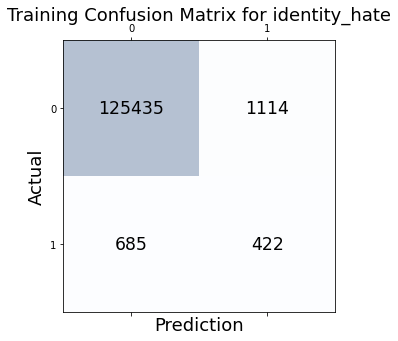

Testing Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     31617
           1       0.29      0.39      0.33       298

    accuracy                           0.99     31915
   macro avg       0.64      0.69      0.66     31915
weighted avg       0.99      0.99      0.99     31915



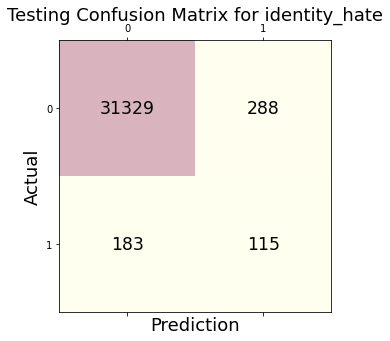

Training Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    114736
           1       0.71      0.74      0.73     12920

    accuracy                           0.94    127656
   macro avg       0.84      0.85      0.85    127656
weighted avg       0.94      0.94      0.94    127656



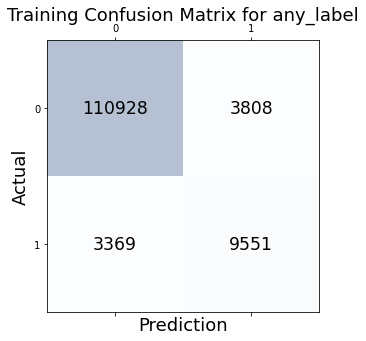

Testing Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     28610
           1       0.71      0.71      0.71      3305

    accuracy                           0.94     31915
   macro avg       0.84      0.84      0.84     31915
weighted avg       0.94      0.94      0.94     31915



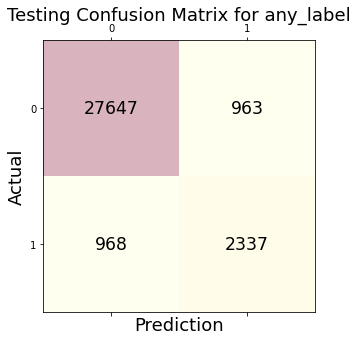

In [19]:
model_evaluate(X_train_validate, y_train_validate, X_test, y_test, 'naiveBayes')

Training Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    115463
           1       0.96      0.84      0.90     12193

    accuracy                           0.98    127656
   macro avg       0.97      0.92      0.94    127656
weighted avg       0.98      0.98      0.98    127656



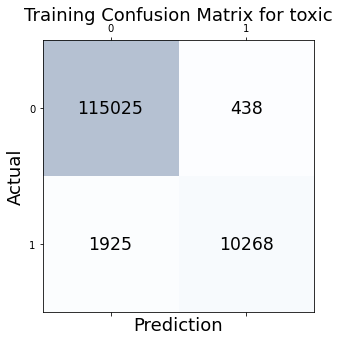

Testing Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28814
           1       0.88      0.71      0.79      3101

    accuracy                           0.96     31915
   macro avg       0.93      0.85      0.88     31915
weighted avg       0.96      0.96      0.96     31915



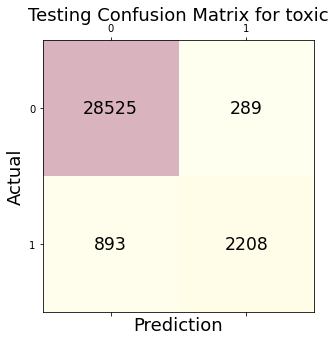

Training Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    126390
           1       0.89      0.68      0.77      1266

    accuracy                           1.00    127656
   macro avg       0.94      0.84      0.88    127656
weighted avg       1.00      1.00      1.00    127656



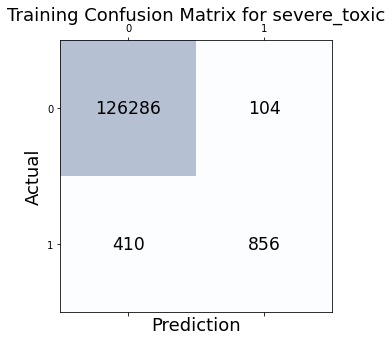

Testing Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     31586
           1       0.50      0.27      0.35       329

    accuracy                           0.99     31915
   macro avg       0.75      0.63      0.67     31915
weighted avg       0.99      0.99      0.99     31915



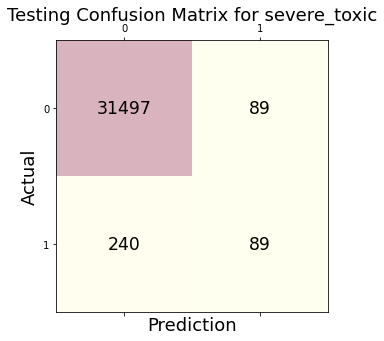

Training Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    120905
           1       0.96      0.88      0.92      6751

    accuracy                           0.99    127656
   macro avg       0.97      0.94      0.96    127656
weighted avg       0.99      0.99      0.99    127656



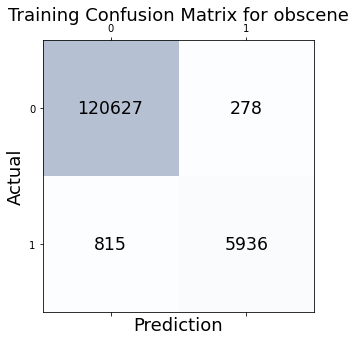

Testing Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     30217
           1       0.87      0.73      0.79      1698

    accuracy                           0.98     31915
   macro avg       0.93      0.86      0.89     31915
weighted avg       0.98      0.98      0.98     31915



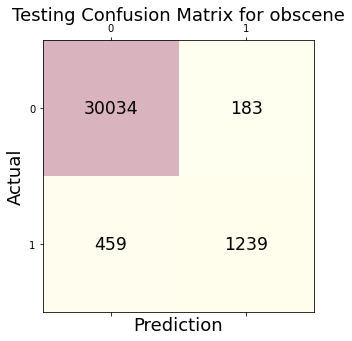

Training Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    127269
           1       0.97      0.80      0.88       387

    accuracy                           1.00    127656
   macro avg       0.99      0.90      0.94    127656
weighted avg       1.00      1.00      1.00    127656



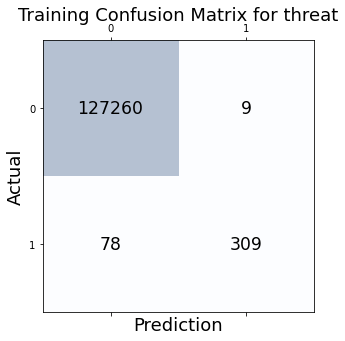

Testing Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31824
           1       0.74      0.29      0.41        91

    accuracy                           1.00     31915
   macro avg       0.87      0.64      0.71     31915
weighted avg       1.00      1.00      1.00     31915



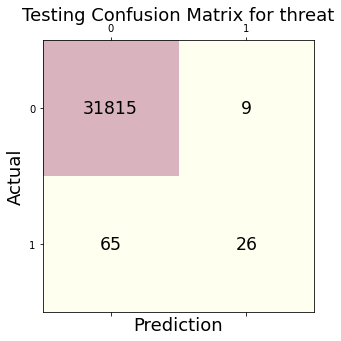

Training Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    121373
           1       0.92      0.81      0.86      6283

    accuracy                           0.99    127656
   macro avg       0.95      0.90      0.93    127656
weighted avg       0.99      0.99      0.99    127656



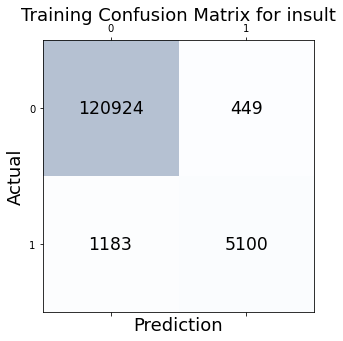

Testing Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     30321
           1       0.79      0.61      0.69      1594

    accuracy                           0.97     31915
   macro avg       0.89      0.80      0.84     31915
weighted avg       0.97      0.97      0.97     31915



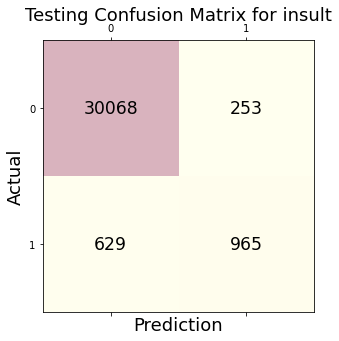

Training Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    126549
           1       0.95      0.67      0.78      1107

    accuracy                           1.00    127656
   macro avg       0.97      0.83      0.89    127656
weighted avg       1.00      1.00      1.00    127656



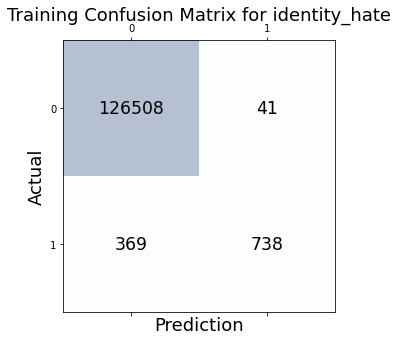

Testing Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     31617
           1       0.66      0.33      0.44       298

    accuracy                           0.99     31915
   macro avg       0.83      0.67      0.72     31915
weighted avg       0.99      0.99      0.99     31915



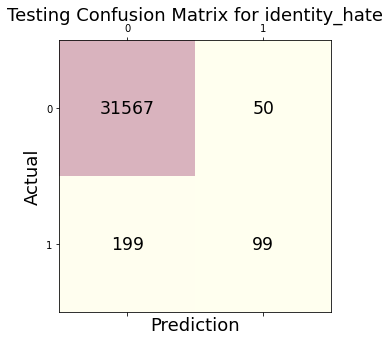

Training Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    114736
           1       0.97      0.85      0.90     12920

    accuracy                           0.98    127656
   macro avg       0.97      0.92      0.95    127656
weighted avg       0.98      0.98      0.98    127656



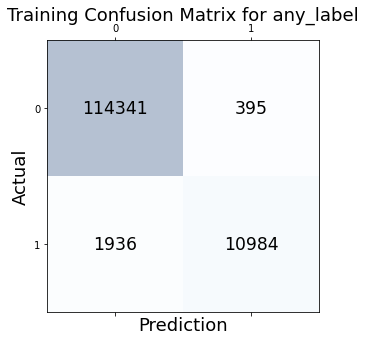

Testing Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28610
           1       0.90      0.73      0.80      3305

    accuracy                           0.96     31915
   macro avg       0.93      0.86      0.89     31915
weighted avg       0.96      0.96      0.96     31915



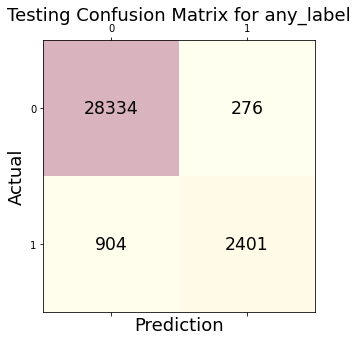

In [20]:
model_evaluate(X_train_validate, y_train_validate, X_test, y_test, 'svm')

Training Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    115463
           1       0.94      0.73      0.82     12193

    accuracy                           0.97    127656
   macro avg       0.96      0.86      0.90    127656
weighted avg       0.97      0.97      0.97    127656



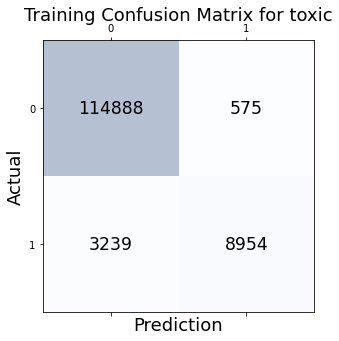

Testing Classification Report for toxic label:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28814
           1       0.90      0.67      0.77      3101

    accuracy                           0.96     31915
   macro avg       0.93      0.83      0.87     31915
weighted avg       0.96      0.96      0.96     31915



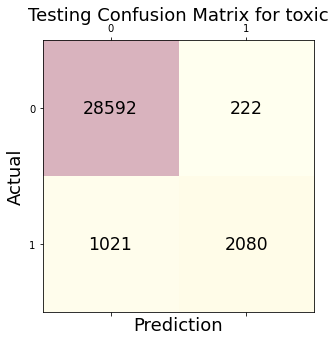

Training Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    126390
           1       0.71      0.40      0.51      1266

    accuracy                           0.99    127656
   macro avg       0.85      0.70      0.75    127656
weighted avg       0.99      0.99      0.99    127656



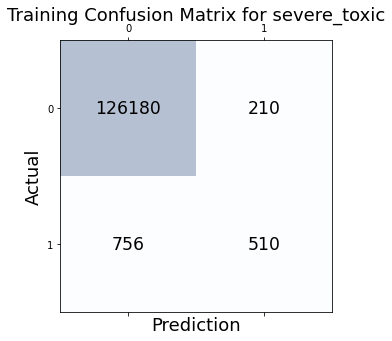

Testing Classification Report for severe_toxic label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     31586
           1       0.55      0.28      0.37       329

    accuracy                           0.99     31915
   macro avg       0.77      0.64      0.68     31915
weighted avg       0.99      0.99      0.99     31915



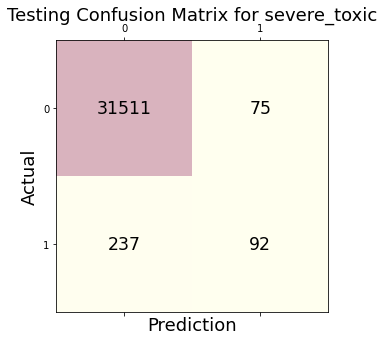

Training Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    120905
           1       0.93      0.76      0.84      6751

    accuracy                           0.98    127656
   macro avg       0.96      0.88      0.91    127656
weighted avg       0.98      0.98      0.98    127656



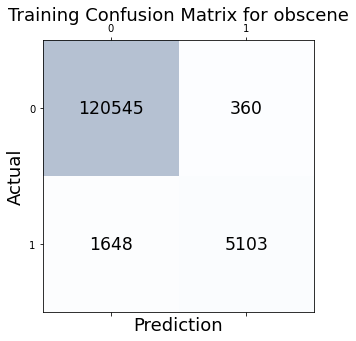

Testing Classification Report for obscene label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     30217
           1       0.90      0.69      0.78      1698

    accuracy                           0.98     31915
   macro avg       0.94      0.84      0.88     31915
weighted avg       0.98      0.98      0.98     31915



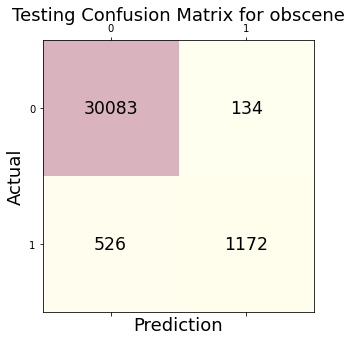

Training Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    127269
           1       0.84      0.31      0.45       387

    accuracy                           1.00    127656
   macro avg       0.92      0.65      0.72    127656
weighted avg       1.00      1.00      1.00    127656



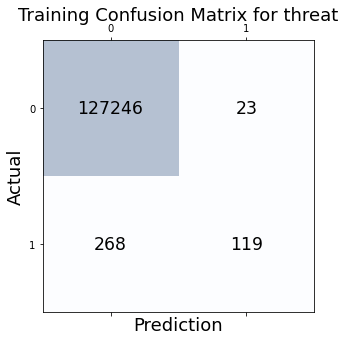

Testing Classification Report for threat label:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31824
           1       0.72      0.25      0.37        91

    accuracy                           1.00     31915
   macro avg       0.86      0.63      0.69     31915
weighted avg       1.00      1.00      1.00     31915



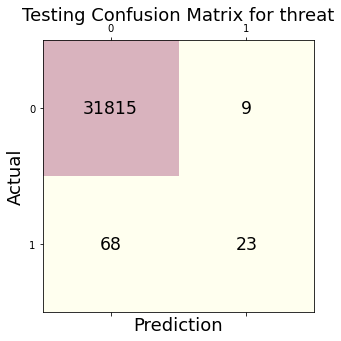

Training Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    121373
           1       0.87      0.66      0.75      6283

    accuracy                           0.98    127656
   macro avg       0.93      0.83      0.87    127656
weighted avg       0.98      0.98      0.98    127656



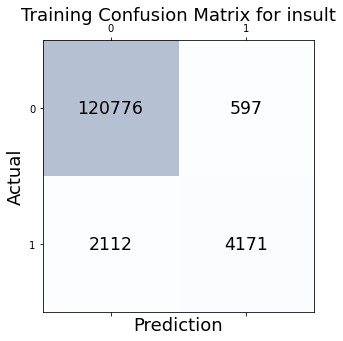

Testing Classification Report for insult label:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     30321
           1       0.82      0.58      0.68      1594

    accuracy                           0.97     31915
   macro avg       0.90      0.79      0.83     31915
weighted avg       0.97      0.97      0.97     31915



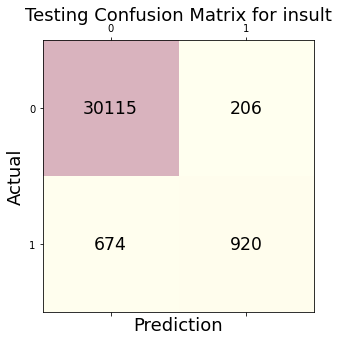

Training Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    126549
           1       0.85      0.35      0.49      1107

    accuracy                           0.99    127656
   macro avg       0.92      0.67      0.74    127656
weighted avg       0.99      0.99      0.99    127656



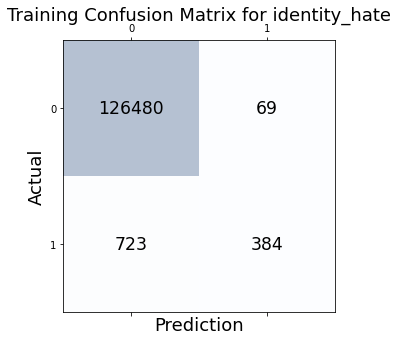

Testing Classification Report for identity_hate label:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     31617
           1       0.68      0.32      0.44       298

    accuracy                           0.99     31915
   macro avg       0.83      0.66      0.72     31915
weighted avg       0.99      0.99      0.99     31915



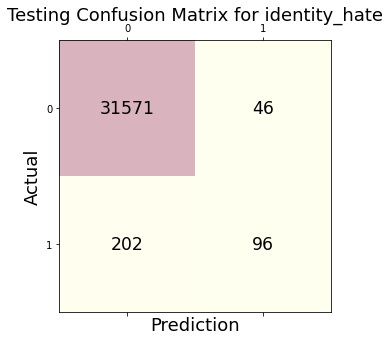

Training Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    114736
           1       0.95      0.74      0.83     12920

    accuracy                           0.97    127656
   macro avg       0.96      0.87      0.91    127656
weighted avg       0.97      0.97      0.97    127656



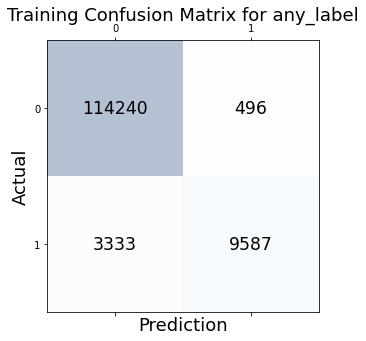

Testing Classification Report for any_label label:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28610
           1       0.91      0.68      0.78      3305

    accuracy                           0.96     31915
   macro avg       0.94      0.83      0.88     31915
weighted avg       0.96      0.96      0.96     31915



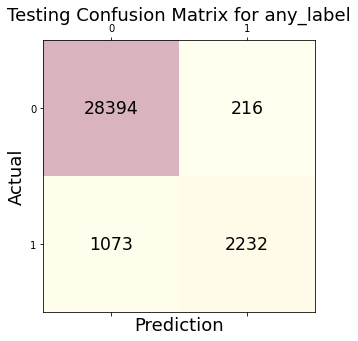

In [21]:
model_evaluate(X_train_validate, y_train_validate, X_test, y_test, 'logisticReg')

In [32]:
test_string = 'This article does not seem to be verified.'
print(predict_custom(test_string, comment_vector, scaler, 'naiveBayes'))
print(predict_custom(test_string, comment_vector, scaler, 'svm'))
print(predict_custom(test_string, comment_vector, scaler, 'logisticReg'))

Your comment is not toxic.
Your comment is not toxic.
Your comment is not toxic.
